# Doubt Solving ReAct Agent

In [2]:
import sys
sys.path.insert(0, '../')
from src.Models.static_assessment import LearningStyleType, PerformanceLevel, SubjectType
from src.Models.base_student import Pace, Student
from src.Models.doubt_bot import DoubtBotRequest, DoubtInput

# example doubt
example_doubt = DoubtBotRequest(
    student=Student(
        student_class=7,
        student_learning_style=LearningStyleType.KINESTHETIC,
        student_performance_from_1_to_100=70,
        student_performance_level=PerformanceLevel.INTERMEDIATE,
        study_pace=Pace.MODERATE
    ),
    doubt= DoubtInput(
        question='What is the value of x in the given image',
        image_url='https://miro.medium.com/v2/resize:fit:786/format:webp/1*OReJHtogeA62SmSwzNzgvw.png',
    ),
    subject=SubjectType.ENGLISH
)

In [101]:
import pprint
pprint.pp(example_doubt.model_dump())

{'student': {'student_class': 7,
             'student_performance_from_1_to_100': 70,
             'student_learning_style': <LearningStyleType.KINESTHETIC: 'kinesthetic'>,
             'student_performance_level': <PerformanceLevel.INTERMEDIATE: 'intermediate'>,
             'study_pace': <Pace.MODERATE: 'moderate'>},
 'doubt': {'question': 'What is the value of x in the given image',
           'image_url': HttpUrl('https://miro.medium.com/v2/resize:fit:786/format:webp/1*OReJHtogeA62SmSwzNzgvw.png'),
           'image_description': None},
 'subject': <SubjectType.ENGLISH: 'english'>}


In [106]:
str(example_doubt.model_dump()['doubt']['image_url'])

'https://miro.medium.com/v2/resize:fit:786/format:webp/1*OReJHtogeA62SmSwzNzgvw.png'

###  Flow for doubt solving - 

1. From given image and question ... create a standard 'Question' that can be understood by the LLM.
2. From that question generate 'Explanation' and image prompt if needed.
3. Combine and return the 'Explanation' and the 'Image-solution'.

In [5]:
# environment
import os
from dotenv import load_dotenv
load_dotenv('../.env')

GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

In [87]:
# example from docs -> will generate answer and image prompt

import httpx
import base64
import google.generativeai as genai
from IPython.display import Markdown

genai.configure(api_key=GEMINI_API_KEY)
# Retrieve an image
image_path = "https://miro.medium.com/v2/resize:fit:786/format:webp/1*OReJHtogeA62SmSwzNzgvw.png"
image = httpx.get(image_path)

# Choose a Gemini model
model = genai.GenerativeModel(model_name="gemini-2.0-flash-exp")

# Create a prompt
prompt = "Solve for x."
response = model.generate_content(
    [
        {
            "mime_type": "image/jpeg",
            "data": base64.b64encode(image.content).decode("utf-8"),
        },
        prompt,
    ]
)

Markdown(">" + response.text)

>The image shows the derivative of x^x. The equation is:

d/dx (x^x) = x^x (1 + ln(x))

There is no solving for x to do here. This is a derivative, not an equation to be solved.  The image simply states what the derivative of x^x is.

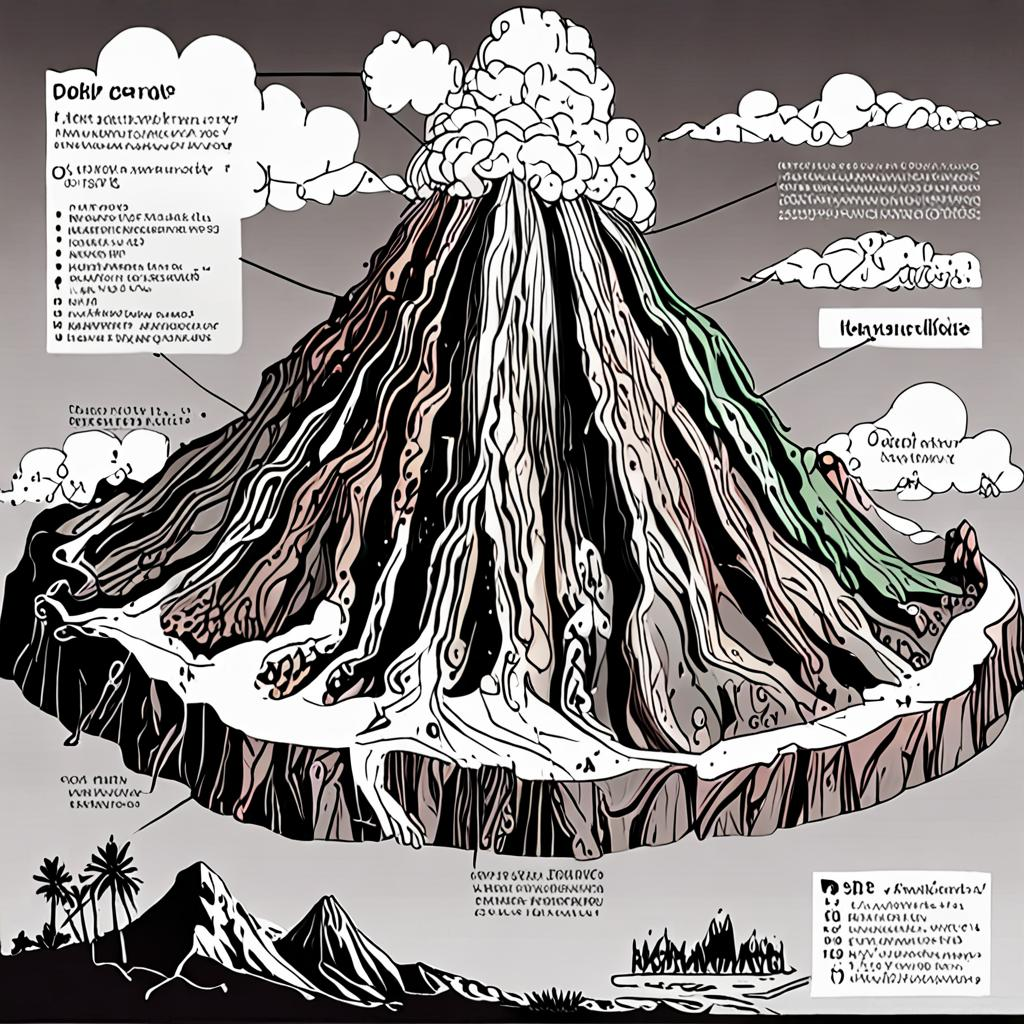

In [68]:
# example from cloudflare -> image prompt to image 

import requests


API_BASE_URL = "https://api.cloudflare.com/client/v4/accounts/a57370fce08c17e1a28c98a558a5e7a3/ai/run/"
headers = {"Authorization": f"Bearer {os.getenv('STABLE_DIFF_CLOUDFLARE')}"}


def run(model, prompt):
    input = { "prompt": prompt }
    response = requests.post(f"{API_BASE_URL}{model}", headers=headers, json=input)
    return response


output = run("@cf/bytedance/stable-diffusion-xl-lightning", prompt = 'diagram of a volcano')
from IPython.display import Image
Image(output.content, height=500, width=500)

_Cant use the imagegen model anymore due to its inability to create accurate illustrations_

### Agentic workflow from here

* Final workflow -
Generate solution response based on given user input (yay)

In [3]:
from fastapi import HTTPException
import httpx
import base64
import google.generativeai as genai
from typing import Optional, Dict, List

class DoubtSolver:
    def __init__(self, gemini_api_key: str):
        genai.configure(api_key=gemini_api_key)
        self.model = genai.GenerativeModel(model_name="gemini-2.0-flash-exp")
        self.response_schema = {
            "type": "object",
            "properties": {
                "explanation": {"type": "string"},
                "key_points": {"type": "array", "items": {"type": "string"}},
                "follow_up_questions": {"type": "array", "items": {"type": "string"}}
            },
            "required": ["explanation", "follow_up_questions"]
        }

    def _construct_prompt(self, doubt: Dict, docs: str) -> str:
        student = doubt['student']
        prompt = f"""**Student Profile:**
- Grade: {student['student_class']}th
- Learning Style: {student['student_learning_style'].value.title()}
- Performance: {student['student_performance_level'].value.title()}
- Pace: {student['study_pace'].value.title()}

**Question:** {doubt['doubt']['question']}
"""

        if docs:
            prompt += f"\n**Relevant Study Materials:**\n{docs}\n"

        if doubt['doubt']['image_description']:
            prompt += f"\n**Image Context:** {doubt['doubt']['image_description']}\n"

        prompt += """
            **Response Requirements:**
            1. Clear explanation tailored to student's profile
            2. 3-5 key points using kinesthetic learning examples
            3. 2-3 follow-up questions to assess understanding

            **Response Format:**
            Explanation: <start here>
            Key Points:
            - <point 1>
            - <point 2>
            Follow-up Questions:
            - <question 1>
            - <question 2>
        """
        return prompt

    def solve_doubt(self, doubt: Dict, docs: str = "") -> Dict:
        parts = []
        
        # Handle image if available
        if doubt['doubt']['image_url']:
            try:
                image = httpx.get(str(doubt['doubt']['image_url'])).content
                parts.append({
                    "mime_type": "image/jpeg",
                    "data": base64.b64encode(image).decode("utf-8"),
                })
            except Exception as e:
                print(f"Error loading image: {e}")

        # Add text prompt
        text_prompt = self._construct_prompt(doubt, docs)
        parts.append(text_prompt)

        # Generate response
        response = self.model.generate_content(parts)
        
        # Parse response
        return self._parse_response(response.text)

    def _parse_response(self, response_text: str) -> Dict:
        sections = {
            "explanation": "",
            "key_points": [],
            "follow_up_questions": []
        }
        current_section = None
        
        for line in response_text.split('\n'):
            line = line.strip()
            if line.lower().startswith("explanation:"):
                current_section = "explanation"
                sections["explanation"] = line[len("explanation:"):].strip()
            elif line.lower().startswith("key points:"):
                current_section = "key_points"
            elif line.lower().startswith("follow-up questions:"):
                current_section = "follow_up_questions"
            elif current_section == "explanation":
                sections["explanation"] += " " + line
            elif current_section == "key_points" and line.startswith("-"):
                sections["key_points"].append(line[1:].strip())
            elif current_section == "follow_up_questions" and line.startswith("-"):
                sections["follow_up_questions"].append(line[1:].strip())
        
        # Clean up explanation
        sections["explanation"] = sections["explanation"].strip()
        
        return sections


/home/gagan/Desktop/resume-projects/SmartEd/ML Service/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:

# Usage Example:
doubt_data = example_doubt

# Assume docs contains relevant material from vector DB
docs_content = """The past perfect tense is used to describe an action that was completed before another action in the past. It is formed with 'had' + past participle. Example: 'She had finished her homework before the movie started.'"""

solver = DoubtSolver(GEMINI_API_KEY)
solution = solver.solve_doubt(doubt_data.model_dump(), docs_content)
print(solution['key_points'])

["**'x' is a variable, not a fixed value:** Imagine 'x' is like a dimmer switch for a light. You can set the dimmer (the 'x' value) to many different levels.", '**d/dx is the rate of change:** Think of it like how fast your bike goes. You can pedal faster or slower. "d/dx" shows how much something (like \'x to the power x\') changes as \'x\' changes.', "**The right side is the formula:** The equation on the right side, `x^x(1 + ln x)`, is the rule (or recipe) for figuring out how fast something changes. Let's say 'x' is 3; we would plug that in and solve for the rate of change at 3.", '**The image shows the solution:** The image shows the general case solution to the derivative of x^x, not the input value for x.']
